<a href="https://colab.research.google.com/github/blankon123/random-analytics/blob/main/Food_101_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cek versi Tensorflow
import tensorflow as tf

print(tf.__version__)

2.5.0


In [2]:
#Download dataset dari kaggle
from google.colab import files

files.upload()

! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d duttadebadri/image-classification

Saving kaggle.json to kaggle.json
100% 2.34G/2.34G [00:49<00:00, 60.7MB/s]
100% 2.34G/2.34G [00:50<00:00, 50.3MB/s]


In [3]:
#Ekstraksi zip
from IPython.display import clear_output

!mkdir images
!unzip -qq image-classification.zip -d images

clear_output()
!ls images

images	test  validation


In [4]:
#Pemeriksaan nama kelas
import os
image_path = 'images/images/images/'
daftar_kelas = os.listdir(image_path)
daftar_kelas

['travel and  adventure', 'food and d rinks', 'architecure', 'art and culture']

In [5]:
#penyamaan nama folder sebagai kelas
!mv images/images/images/food\ and\ d\ rinks images/images/images/food

In [17]:
#Kelas pilihan
kelas = ['travel and  adventure', 'food', 'architecure']

#Jumlah sampel gambar
sample_number = 0

for k in kelas:
  totalFiles = 0
  for base, dirs, files in os.walk(image_path+'/'+k):
      for Files in files:
          totalFiles += 1
  print('Total Files di',k,totalFiles)
  sample_number += totalFiles

print('Total Training ',sample_number)
print('Total Kelas ',len(kelas))

Total Files di travel and  adventure 8800
Total Files di food 8782
Total Files di architecure 8763
Total Training  26345
Total Kelas  3


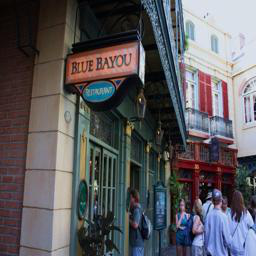

(256, 256, 3) travel and  adventure/Places365_val_00010156.jpg


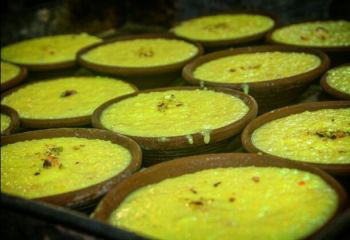

(240, 350, 3) food/fDGLknhl4CSFclFnejtH.jpg


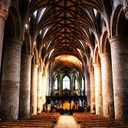

(128, 128, 3) architecure/8102001067_1da875a323_m.jpg


In [18]:
import cv2 as cv 
from google.colab.patches import cv2_imshow
from skimage import io

#Menampilkan beberapa contoh gambar
lokasis = [k+'/'+os.listdir(image_path+k)[1] for k in kelas]

for lokasi in lokasis:
  image = io.imread(image_path+lokasi) 
  image_2 = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  cv2_imshow(image_2)
  print(image_2.shape, lokasi)

In [19]:
import pandas as pd
df = pd.DataFrame(columns=['lokasi','kelas'])

for k in kelas:
  df = df.append([{'lokasi':k+'/'+f,'kelas':k} for f in os.listdir(image_path+k)])

# periksa dataframe
df.kelas.unique()

array(['travel and  adventure', 'food', 'architecure'], dtype=object)

In [36]:
from sklearn.model_selection import train_test_split

# membagi dataset menjadi training dan testing dengan pertimbangan sratifikasi y
x_train, x_test, y_train, y_test = train_test_split(df.lokasi, df.kelas, test_size=0.2,random_state=42,stratify=df.kelas)

train_set = pd.DataFrame({'lokasi': x_train, 'kelas': y_train}, columns=['lokasi', 'kelas'])
test_set = pd.DataFrame({'lokasi': x_test, 'kelas': y_test}, columns=['lokasi', 'kelas'])

# periksa ukuran agar sesuai dengan permintaan soal
print('Ukuran Train Set :',len(x_train),' Test Set :',len(x_test))

# periksa proporsi kelas
print(y_train.value_counts()/y_test.value_counts())

train_set.head()

Ukuran Train Set : 21076  Test Set : 5269
travel and  adventure    4.000000
food                     4.001139
architecure              3.998859
Name: kelas, dtype: float64


,lokasi,kelas
3016,travel and adventure/Places365_val_00008863.jpg,travel and adventure
351,travel and adventure/Places365_val_00007112.jpg,travel and adventure
2777,architecure/5443861517_57f4550804_n.jpg,architecure
7523,architecure/16174120331_f682b61bce_m.jpg,architecure
8550,architecure/4987791440_ff2c5d7f1c_n.jpg,architecure


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Augmentation pada dataset
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255
                    )

# inisiasi ukuran pixel yang diinginkan
ukuran_target = (224,224)

In [22]:
train_generator = train_datagen.flow_from_dataframe(
        train_set,  # dataframe data latih
        directory=image_path,
        x_col='lokasi',
        y_col='kelas',
        target_size=ukuran_target,
        batch_size=10,
        # karena kita merupakan masalah klasifikasi >2 kelas maka menggunakan class_mode = 'categorical'
        class_mode='categorical')
 
validation_generator = test_datagen.flow_from_dataframe(
        test_set,  # dataframe data test
        directory=image_path,
        x_col='lokasi',
        y_col='kelas',
        target_size=ukuran_target,
        batch_size=10,
        # karena kita merupakan masalah klasifikasi >2 kelas maka menggunakan class_mode = 'categorical'
        class_mode='categorical')

Found 21075 validated image filenames belonging to 3 classes.
Found 5268 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="lokasi". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="lokasi". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [23]:
tf.keras.backend.clear_session()

#Agar hasil yang diinginkan dapat relatif baik dengan training time yang singkat, digunakan transfer learning
model = tf.keras.models.Sequential([
    tf.keras.applications.InceptionV3(weights='imagenet', include_top=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(kelas),activation='softmax')
])

model.layers[0].trainable = False

In [24]:
#Karena proses training berjalan lama, diperlukan callback agar ketika goal tercapai (Akurasi>92) , epoch selanjutnya tidak diperlukan
acc = 0.92

class myCallback(tf.keras.callbacks.Callback): 
  def on_epoch_end(self, epoch, logs={}): 
    if(logs.get('val_accuracy')>acc and logs.get('accuracy')>acc): 
      print("\ACC >",acc,"!") 
      self.model.stop_training = True 

callbacks = myCallback() 

In [37]:
# compile model
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

# Print isi dari CNN
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
batch_normalization_94 (Batc (None, None, None, 2048)  8192      
_________________________________________________________________
conv2d_94 (Conv2D)           (None, None, None, 128)   2359424   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, None, None, 128)   0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [26]:
# latih model dengan model.fit 
history = model.fit(
            train_generator,
            callbacks=[callbacks],
            steps_per_epoch=10,  # berapa batch yang akan dieksekusi pada setiap epoch
            epochs=30, # tambahkan epochs jika akurasi model belum optimal
            validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
            validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
            verbose=1
            )

Epoch 1/30
5/5 [==============================] - 20s 3s/step - loss: 1.1685 - accuracy: 0.6600 - val_loss: 1.3941 - val_accuracy: 0.7000
Epoch 2/30
5/5 [==============================] - 13s 3s/step - loss: 1.0327 - accuracy: 0.7800 - val_loss: 2.1331 - val_accuracy: 0.7600
Epoch 3/30
5/5 [==============================] - 12s 3s/step - loss: 0.9864 - accuracy: 0.7800 - val_loss: 2.1694 - val_accuracy: 0.6400
Epoch 4/30
5/5 [==============================] - 12s 3s/step - loss: 1.5025 - accuracy: 0.7400 - val_loss: 0.6483 - val_accuracy: 0.8000
Epoch 5/30
5/5 [==============================] - 13s 3s/step - loss: 2.1836 - accuracy: 0.7200 - val_loss: 1.1949 - val_accuracy: 0.7400
Epoch 6/30
5/5 [==============================] - 13s 3s/step - loss: 1.2590 - accuracy: 0.7000 - val_loss: 1.7605 - val_accuracy: 0.7400
Epoch 7/30
5/5 [==============================] - 13s 3s/step - loss: 0.7088 - accuracy: 0.8800 - val_loss: 2.4096 - val_accuracy: 0.7600
Epoch 8/30
5/5 [==================

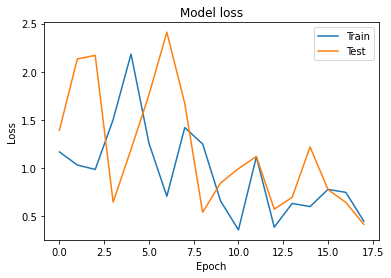

In [27]:
import matplotlib.pyplot as plt 

plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train','Test'], loc='upper right') 
plt.show() 

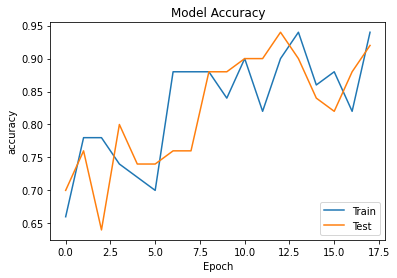

In [28]:
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('Model Accuracy')
plt.ylabel('accuracy') 
plt.xlabel('Epoch') 
plt.legend(['Train','Test'], loc='lower right') 
plt.show() 

In [29]:
# Konversi model. 
converter = tf.lite.TFLiteConverter.from_keras_model(model) 
tflite_model = converter.convert() 

INFO:tensorflow:Assets written to: /tmp/tmpngjh_8f2/assets


In [30]:
#Serialize model ke file 
with tf.io.gfile.GFile('model.tflite', 'wb') as f: 
  f.write(tflite_model) 